# $2^k$ A*





In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
EPS = 0.000001

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


### Grid map representation and allowed moves on a grid

Square grid map class represents agent's environment

- width -- the number of rows in grid
- height -- the number of columns in grid
- cells -- the binary matrix, which represents the grid. 0 - cell is traversable
1 - cell is blocked

In [2]:
import math

class Map:

    # Default constructor
    def __init__(self,k):
        self.k = k
        self.width = 0
        self.height = 0
        self.cells = []
    
    # Initialization of map by string.
    def ReadFromString(self, cellStr, width, height):
        self.width = width
        self.height = height
        self.cells = [[0 for _ in range(width)] for _ in range(height)]
        cellLines = cellStr.split("\n")
        i = 0
        j = 0
        for l in cellLines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self.cells[i][j] = 0
                    elif c == '#':
                        self.cells[i][j] = 1
                    else:
                        continue
                    j += 1
                # TODO
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
    # Initialization of map by list of cells.
    def SetGridCells(self, width, height, gridCells):
        self.width = width
        self.height = height
        self.cells = gridCells

    # Check if the cell is on a grid.
    def inBounds(self, i, j):
        return (0 <= j < self.width) and (0 <= i < self.height)
    
    # Check if thec cell is not an obstacle.
    def Traversable(self, i, j):
        return not self.cells[i][j]
    
    # Checks cell is not obstacle.
    def Traversable_(self, i, j, x, y):
        ans = True
        dx = x - i
        dy = y - j
        if dy == 0 or dx == 0:
            return not self.cells[x][y]
          
        d_max = max(abs(dx), abs(dy))

        if d_max == abs(dy):
            if dy > 0:
                for delta_y in range(1, dy + 1):
                    delta_x = dx*delta_y/dy
                    if abs(round(delta_x) - delta_x) < 10e-6:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)]:
                            ans = False
                    else:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)] or self.cells[i + math.floor(delta_x) + 1][j + math.floor(delta_y)]:
                            ans = False
            else:
                for delta_y in range(dy, 0):               
                    delta_x = dx*delta_y/dy
                    if abs(round(delta_x) - delta_x) < 10e-6:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)]:
                            ans = False
                    else:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)] or self.cells[i + math.floor(delta_x) + 1][j + math.floor(delta_y)]:
                            ans = False
        else:
            if dx > 0:
                for delta_x in range(1, dx + 1):
                    delta_y = dy*delta_x/dx
                    if abs(round(delta_y) - delta_y) < 10e-6:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)]:
                            ans = False
                    else:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)] or self.cells[i + math.floor(delta_x)][j + math.floor(delta_y) + 1]:
                            ans = False
            else:
                for delta_x in range(dx, 0):               
                    delta_y = dy*delta_x/dx
                    if abs(round(delta_y) - delta_y) < 10e-6:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)]:
                            ans = False
                    else:
                        if self.cells[i + math.floor(delta_x)][j + math.floor(delta_y)] or self.cells[i + math.floor(delta_x)][j + math.floor(delta_y) + 1]:
                            ans = False
        return ans

    # Creates a list of neighbour cells as (i,j) tuples.
    def GetNeighbors(self, i, j):

        neighbors = [(0,1), (1,0)]
        number_of_vectors = len(neighbors)
        current_i = i
        current_j = j
        
        for i in range(3,self.k+1):
          n_new = 2**(i-2) + 1
          new_neighbors = [0]*n_new
          for n,_ in enumerate(new_neighbors):
            if n % 2 == 0:
              new_neighbors[n] = neighbors[int(n/2)]
            else:
              new_neighbors[n] = (neighbors[int(n/2)][0] + neighbors[int(n/2) + 1][0], neighbors[int(n/2)][1] + neighbors[int(n/2)+1][1])
          neighbors = new_neighbors

        final_neighbors = []
        for i, j in neighbors:
          final_neighbors.append((i,j))
          final_neighbors.append((-i,j))
          final_neighbors.append((i,-j))
          final_neighbors.append((-i,-j))

        final_final_neighbors = []
        for i, j in list(set(final_neighbors)):
          if self.inBounds(i + current_i, j + current_j):
            if self.Traversable_(current_i, current_j, current_i + i, current_j + j):
              final_final_neighbors.append((i, j))
        return list(set(final_final_neighbors))

    def get_moves_list(self):
        neighbors = [(1,0),(0,1)]

        for i in range(3,self.k+1):
          n_new = 2**(i-2) + 1
          new_neighbors = [0]*n_new
          for n,_ in enumerate(new_neighbors):
            if n % 2 == 0:
              new_neighbors[n] = neighbors[int(n/2)]
            else:
              new_neighbors[n] = (neighbors[int(n/2)][0] + neighbors[int(n/2) + 1][0], neighbors[int(n/2)][1] + neighbors[int(n/2)+1][1])
          neighbors = new_neighbors

        final_neighbors = []
        for i, j in neighbors:
          final_neighbors.append((i,j))
        for i, j in neighbors[::-1]:
          if i!=0:
            final_neighbors.append((-i,j))
        for i, j in neighbors:
          if j!=0:
            final_neighbors.append((-i,-j))
        for i, j in neighbors[::-1]:
          if i*j!=0:
            final_neighbors.append((i,-j))
        return final_neighbors

Computes a cost of transition from cell `(i1, j1)` to cell `(i2, j2)`

In [3]:
def CalculateCost(i1, j1, i2, j2):
    return math.sqrt((i1 - i2) ** 2 + (j1 - j2) ** 2)

### Node representation

Node class represents a search node

- i, j: coordinates of corresponding grid element
- g: g-value of the node
- h: h-value of the node
- F: f-value of the node
- parent: pointer to the parent-node 

In [4]:
class Node:
    def __init__(self, i, j, g = math.inf, h = math.inf, F = None, parent = None, movement = None, k=0):
        self.i = i
        self.j = j
        self.g = g
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
        self.movement = movement
        self.k = k
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)
    
    def __lt__(self, other):
        return self.F < other.F or (self.F == other.F and self.k > other.k)

In [5]:
def Draw(gridMap : Map, start : Node = None, goal : Node = None, path : list = None, nodesExpanded = None, nodesOpened = None):
    k = 5
    hIm = gridMap.height * k
    wIm = gridMap.width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap.height):
        for j in range(gridMap.width):
            if(gridMap.cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        for node in nodesOpened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        for node in nodesExpanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (gridMap.Traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (gridMap.Traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (gridMap.Traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))

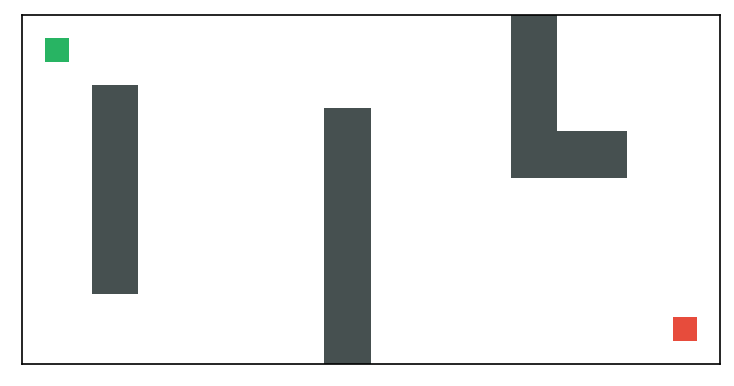

In [ ]:
height = 15
width = 30
mapstr = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

testMap = Map(k = 2)
testMap.ReadFromString(mapstr, width, height)
start = Node(1, 1)
goal = Node(13, 28)
Draw(testMap, start, goal)

### Open and close sets implementation
A crucial part of any search algorithm (A* including) is the code for handling OPEN/CLOSED 'lists'. Ineffective implementation of these 'lists' may become a bottleneck, expecially for large instances. So try your best to implement OPEN and CLOSED efficiently and correctly.

In [6]:
from heapq import heappop, heappush

class YourOpen:
    #!!!TODO!!!
    #Create your own modification of OPEN#
    def __init__(self):
        self.heap = []
        self.ij_to_item = {}
    
    def __iter__(self):
        return iter(self.ij_to_item.values())

    def __len__(self):
        return len(self.ij_to_item)

    def isEmpty(self):
        return len(self.ij_to_item) == 0

    def GetBestNode(self):
        item = heappop(self.heap)
        ij = (item.i, item.j)
        while self.ij_to_item.pop(ij, None) is None:
            item = heappop(self.heap)
            ij = (item.i, item.j)
        return item

    def AddNode(self, item : Node):
        ij = (item.i, item.j)
        item_curr = self.ij_to_item.get(ij)
        if item_curr is None or item.g < item_curr.g or abs(item.g - item_curr.g) < EPS:
            self.ij_to_item[ij] = item
            heappush(self.heap, item)


In [7]:
class YourClosed:
    #!!!TODO!!!
    #Create your own modification of CLOSED#

    def __init__(self):
        self.elements = {}

    def __iter__(self):
        return iter(self.elements.values())
    
    def __len__(self):
        return len(self.elements)
    
    # AddNode is the method that inserts the node to CLOSED
    def AddNode(self, item : Node, *args):
        ij = item.i, item.j
        self.elements[ij] = item

    # WasExpanded is the method that checks if a node has been expanded
    def WasExpanded(self, item : Node, *args):
        ij = item.i, item.j
        return ij in self.elements


## A* algorithm with different heuristics
Implement 3 different heuristic functions besides the given Manhattan distance - Diagonal distance, Chebyshev distance, Euclidean distance. After that, implement A* using YourOpen and YourClosed.

Importanly, your search algorithm needs to return the following:
- boolean flag indicating whether the path was found or not
- goal state (so you can reconstruct the path later using the parent pointers)
- Open and Closed 'lists' so you can use them for further analysis (i.e. computing how many nodes were created within the search process, how many expansions were made etc.)

In [8]:
import numpy as np

def h_4(x, y):
    return x + y

def h_8(x, y):
    if x > y:
        x, y = y, x
    return y - x + np.sqrt(2)*x

def h_16(x, y):
    if x > y:
        x, y = y, x
    if 2*x < y:
        return y - 2*x + np.sqrt(5)*x
    else:
        return np.sqrt(5)*(y - x) + np.sqrt(2)*(2*x - y)

def h_32(x, y):
    if x > y:
        x, y = y, x
    if 3*x < y:
        return (y - 3*x) + np.sqrt(10)*x
    elif 2*x < y:
        return np.sqrt(10)*(y - 2*x) + np.sqrt(5)*(3*x - y)
    elif 3*x < 2*y :
        return np.sqrt(5)*(2*y - 3*x) + np.sqrt(13)*(2*x - y)
    else:
      return np.sqrt(13)*(y - x) + np.sqrt(2)*(3*x - 2*y)

def h_64(x,y):
    if x > y:
        x, y = y, x
    if 4*x < y:
      return (y - 4*x) + np.sqrt(17)*x
    elif 3*x < y :
      return np.sqrt(17)*(y - 3*x) + np.sqrt(10)*(4*x - y)
    elif 5*x < 2*y:
      return np.sqrt(10)*(2*y - 5*x) + np.sqrt(29)*(3*x - y)
    elif 2*x < y:
      return np.sqrt(29)*(y - 2*x) + np.sqrt(5)*(5*x - 2*y)
    elif 5*x <3*y :
      return np.sqrt(5)*(3*y - 5*x) + np.sqrt(34)*(2*x - y)
    elif 3*x < 2*y :
      return np.sqrt(34)*(2*y - 3*x) + np.sqrt(13)*(5*x - 3*y)
    elif 4*x < 3*y:
      return np.sqrt(13)*(3*y - 4*x) + 5*(3*x - 2*y)
    else:
      return 5*(y - x) + np.sqrt(2)*(4*x - 3*y)



In [ ]:
h_16(12, 27)

29.832815729997478

In [9]:
def AStar(gridMap : Map, k : int, iStart : int, jStart : int, iGoal : int, jGoal : int):

    OPEN = YourOpen()
    CLOSED = YourClosed()
    all_moves = gridMap.get_moves_list()
    if k == 2:
        h = h_4
    elif k == 3:
        h = h_8
    elif k == 4:
        h = h_16
    elif k == 5:
        h = h_32
    elif k == 6:
        h = h_64
    else:
        print('choose another k, please')
    node_start = Node(iStart, jStart, g=0, h=h(iGoal - iStart, jGoal - jStart))
    node_goal = Node(iGoal, jGoal, h = 0)
    OPEN.AddNode(node_start)
    node_start = OPEN.GetBestNode()
    for x, y in gridMap.GetNeighbors(node_start.i, node_start.j):
        OPEN.AddNode(Node(node_start.i + x, node_start.j + y, g = CalculateCost(node_start.i, node_start.j, node_start.i + x, node_start.j + y), h = h(abs(node_start.i + x - iGoal), abs(node_start.j + y - jGoal)), parent = node_start, movement = (x, y)))
    CLOSED.AddNode(node_start)

    while not OPEN.isEmpty():
        node = OPEN.GetBestNode()
        CLOSED.AddNode(node)
        if node == node_goal:
            return True, node, CLOSED, OPEN
        neighbors_list = gridMap.GetNeighbors(node.i, node.j)
        if all_moves.index(node.movement) % 2 != 0:
            if all_moves[all_moves.index(node.movement)] in neighbors_list and not CLOSED.WasExpanded(Node(node.i + all_moves[all_moves.index(node.movement)][0], node.j + all_moves[all_moves.index(node.movement)][1])):
                OPEN.AddNode(Node(node.i + all_moves[all_moves.index(node.movement)][0], node.j + all_moves[all_moves.index(node.movement)][1], parent = node, movement = node.movement, g = node.g + CalculateCost(node.i, node.j, node.i + all_moves[all_moves.index(node.movement)][0], node.j + all_moves[all_moves.index(node.movement)][1]), h = h(abs(iGoal - node.i - all_moves[all_moves.index(node.movement)][0]), abs(jGoal - node.j - all_moves[all_moves.index(node.movement)][1]))))
            if all_moves[(all_moves.index(node.movement) + 1)%len(all_moves)] in neighbors_list and not CLOSED.WasExpanded(Node(node.i + all_moves[(all_moves.index(node.movement) + 1)%len(all_moves)][0], node.j + all_moves[(all_moves.index(node.movement) + 1)%len(all_moves)][1])):
                OPEN.AddNode(Node(node.i + all_moves[(all_moves.index(node.movement) + 1)%len(all_moves)][0], node.j + all_moves[(all_moves.index(node.movement) + 1)%len(all_moves)][1], parent = node, movement = all_moves[(all_moves.index(node.movement) + 1)%len(all_moves)], g = node.g + CalculateCost(node.i, node.j, node.i + all_moves[(all_moves.index(node.movement) + 1)%len(all_moves)][0], node.j + all_moves[(all_moves.index(node.movement) + 1)%len(all_moves)][1]), h = h(abs(iGoal - node.i - all_moves[(all_moves.index(node.movement) + 1)%len(all_moves)][0]), abs(jGoal - node.j - all_moves[(all_moves.index(node.movement) + 1)%len(all_moves)][1]))))
            if all_moves[(all_moves.index(node.movement) - 1)%len(all_moves)] in neighbors_list and not CLOSED.WasExpanded(Node(node.i + all_moves[(all_moves.index(node.movement) - 1)%len(all_moves)][0], node.j + all_moves[(all_moves.index(node.movement) - 1)%len(all_moves)][1])):
                OPEN.AddNode(Node(node.i + all_moves[(all_moves.index(node.movement) - 1)%len(all_moves)][0], node.j + all_moves[(all_moves.index(node.movement) - 1)%len(all_moves)][1], parent = node, movement = all_moves[(all_moves.index(node.movement) - 1)%len(all_moves)], g = node.g + CalculateCost(node.i, node.j, node.i + all_moves[(all_moves.index(node.movement) - 1)%len(all_moves)][0], node.j + all_moves[(all_moves.index(node.movement) - 1)%len(all_moves)][1]), h = h(abs(iGoal - node.i - all_moves[(all_moves.index(node.movement) - 1)%len(all_moves)][0]), abs(jGoal - node.j - all_moves[(all_moves.index(node.movement) - 1)%len(all_moves)][1]))))
        else:
            if all_moves[all_moves.index(node.movement)] in neighbors_list and not CLOSED.WasExpanded(Node(node.i + all_moves[all_moves.index(node.movement)][0], node.j + all_moves[all_moves.index(node.movement)][1])):
                OPEN.AddNode(Node(node.i + all_moves[all_moves.index(node.movement)][0], node.j + all_moves[all_moves.index(node.movement)][1], parent = node, movement = node.movement, g = node.g + CalculateCost(node.i, node.j, node.i + all_moves[all_moves.index(node.movement)][0], node.j + all_moves[all_moves.index(node.movement)][1]), h = h(abs(iGoal - node.i - all_moves[all_moves.index(node.movement)][0]), abs(jGoal - node.j - all_moves[all_moves.index(node.movement)][1]))))
        p = [(i + node.parent.i, j + node.parent.j) for i, j in gridMap.GetNeighbors(node.parent.i, node.parent.j)]
        for x, y in neighbors_list:
            new = Node(x + node.i, y + node.j)
            p_new = [(i + new.i, j + new.j) for i, j in gridMap.GetNeighbors(node.i + x, node.j + y)] 
            joints = list(set(p) & set(p_new))
            d_min = 10e8
            check = []
            for joint in joints:
                 if CalculateCost(node.parent.i, node.parent.j, joint[0], joint[1]) + CalculateCost(joint[0],joint[1], node.i+x, node.j+y) < d_min:
                     d_min = CalculateCost(node.parent.i, node.parent.j, joint[0], joint[1]) + CalculateCost(joint[0],joint[1], node.i+x, node.j+y)
            for joint in joints:
                if abs(d_min - CalculateCost(node.parent.i, node.parent.j, joint[0], joint[1]) - CalculateCost(joint[0], joint[1], node.i + x, node.j + y)) < 10e-5:
                    check.append((joint[0], joint[1]))

            if len(check) == 1:
                if check[0][0] == node.i and check[0][1] == node.j and not CLOSED.WasExpanded(Node(node.i + x, node.j + y, parent = node, movement = (x,y), g = node.g + CalculateCost(node.i,node.j,node.i+x,node.j+y), h = h(abs(iGoal - (node.i+x)), abs(jGoal - (node.j+y))))):              
                    OPEN.AddNode(Node(node.i + x, node.j + y, parent = node, movement = (x,y), g = node.g + CalculateCost(node.i,node.j,node.i+x,node.j+y), h = h(abs(iGoal - (node.i+x)), abs(jGoal - (node.j+y)))))



    return (False, None, CLOSED, OPEN)

### Make Path
This is an auxiliary function that reconstructs a path (i.e. the sequence on moves from start to goal) given a search tree, created by the search algorithm. It basically unwinds the path using the parent pointers. It also returns a length of the path.

In [10]:
def MakePath(goal):
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

### Simple Single Test
This function helps you to run a test of your search algorithm on a single instance (map + start + goal) and validate the result (provided that you know the correct answer to the path finding query and pass it as a parameter).

In [11]:
def SimpleTest(SearchFunction, k, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, *args):
    taskMap = Map(k)
    taskMap.ReadFromString(mapstr, width, height)
    start = Node(iStart, jStart)
    goal = Node(iGoal, jGoal)

    try:
        result = SearchFunction(taskMap, k, start.i, start.j, goal.i, goal.j, *args)
        nodesExpanded = result[2]
        nodesOpened = result[3]
        if result[0]:
            path = MakePath(result[1])
            correct = abs(path[1] - pathLen) < EPS
            print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
            Draw(testMap, start, goal, path[0], nodesExpanded, nodesOpened)
        else:
            print("Path not found!")
            Draw(testMap, start, goal, None, nodesExpanded, nodesOpened)
    except Exception as e:
        print("Execution error")
        print(e)

### Proccessing the Input Data and Storing the Results 
Recall that in this lab you have to use [[MovingAI](https://movingai.com/benchmarks/grids.html)] benchmark as a source dataset for you experiments. So you need to implement functions that will read the data from the dataset, running tests (with validating that your answer is a correct one) and store the obtained results for further analysis.


You can use the provided function definitions to organize your work with the benchmark.

In [12]:
def ReadMapFromMovingAIFile(path, k):
    #!!!TODO!!!
    mapping = {'.': '.', 'G': '.', '@': '#', 'O': '#', 'T': '#', '\n': '\n'}
    with open(path, 'r') as f:
        f.readline()
        H = int(f.readline().split()[1])
        W = int(f.readline().split()[1])
        f.readline()
        map_str = ''.join(f.readlines())
    map_str = ''.join(map(lambda x: mapping[x], map_str))
    m = Map(k = k)
    m.ReadFromString(map_str, W, H)
    return m

In [13]:
def ReadTasksFromMovingAIFile(path):
    #!!!TODO!!!
    tasks = []
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            bucket, map_file, W, H, iStart, jStart, iGoal, jGoal, pathLen = line.split()
            tasks.append((map_file, int(iStart), int(jStart), int(iGoal), int(jGoal), float(pathLen)))
    return tasks 

In [14]:
from tqdm import tqdm
def MassiveTest(SearchFunction, k, tasks, map_file_prefix, *args):
    allTasksResults = {'found': [], 'length': [], 'true_length': [], 'is_optimal': [], 
                       'nodes_created': [], 'number_of_steps': []}
    #!!!TODO!!!
    for map_file, iStart, jStart, iGoal, jGoal, pathLen in tqdm(tasks):
        allTasksResults['true_length'].append(pathLen)
        #m = Map(k = 2)
        m = ReadMapFromMovingAIFile(map_file_prefix + map_file, k = k)
        result = SearchFunction(m, k, jStart, iStart, jGoal, iGoal, *args)
        nodesExpanded = result[2]
        nodesOpened = result[3]
        nodes_created = len(nodesOpened) + len(nodesExpanded)
        number_of_steps = len(nodesExpanded)
        allTasksResults['nodes_created'].append(nodes_created)
        allTasksResults['number_of_steps'].append(number_of_steps)
        if result[0]:
            path = MakePath(result[1])
            correct = abs(path[1] - pathLen) < EPS
            allTasksResults['found'].append(True)
            allTasksResults['length'].append(path[1])
            allTasksResults['is_optimal'].append(correct)
        else:
            allTasksResults['found'].append(False)
            allTasksResults['length'].append(None)
            allTasksResults['is_optimal'].append(None)
            
    return allTasksResults

## Now it's time to run simple test

In [ ]:
height = 15
width = 30
mapstr = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''
iStart = 1
jStart = 1
iGoal = 13
jGoal = 28
pathLen = 31.9705627
#AStar(gridMap : Map, k : int, iStart : int, jStart : int, iGoal : int, jGoal : int)

In [15]:
height = 80
width = 211
mapstr = '''
###################################################################################################################################################################################################################
###################################################################################################################################################################################################################
##############################################################################################################################.####################################################################################
##############################################################################################################################.####################################################################################
#################################################################################.............##..............################.#################..............##............#######################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
################################################################################.............................................................................................######################################
################################################################################..............................................#..............................................######################################
#################################################################################............####################............####............###################...........########################################
###################################################################################........##########################....############....##########################........########################################
####################################################################################.......##########################....############....##########################........########################################
####################################################################################.......##########################....############....##########################........########################################
###########....########################......#######################################.......##########.#############........########........########################........########################.###############
###########....########################......######################..####.##########.......##########.###########............####............######################........###############.########.###############
###########..................................#####################........##########.......##########.##...................................................########........##########........####.........#########
##########...................................#####################........##########.......##########.##...................................................########........##########.....................#########
##########...................................##################.......................................##......................................................#####........................................########
##########...................................##################.......................................##......................................................##..........................................#########
##########...................................####################.....................................##......................................................##................##........................#########
##########...................................####################.....................................##......................................................##................##........................#########
##########...................................####################.....................................##......................................##......##......##................##.........................########
##########...................................####################.....................................##########################################......##########................##...........................######
###########..................................####################.....................................########.......#####.......#####.......###......##########..........................................#########
###########..................................####################.............................................................................##########................................###...............#########
#########......####......####......####......###################..............................................................................##########...............................####...............#########
##########.....####......####......####......####################.............................................................................####..####................................##................#########
##########.....####......####......####......####################..................................................................................................................................######.#########
########.......####......####......####.......#################....................................................................................................................................################
######..........##..................##..........#############......................................................................................................................................################
#####.............................................##########.......................................................................................................................................################
###................................................#######............................................................................................................................................#############
......................................................................................................................................................................................................#############
.....................................................................................................................................................................................................##############
.....................................................................................................................................................................................................##############
.....................................................................................................................................................................................................##############
.....................................................................................................................................................................................................##############
......................................................................................................................................................................................................#############
......................................................................................................................................................................................................#############
####...............................................########........................................................................................................................................################
######............................................###########......................................................................................................................................################
########........##..................##..........###############...................................................................................................................................#################
#########......####......####......####.......##################..................................................................................................................................#######...#######
##########.....####......####......####......####################.......................................................................................................................#..........####...#########
#########......####......####......####......####################.............................................................................##########...............................###................#########
##########.....####......####......####......###################..............................................................................##########...............................####...............#########
###########..................................##################...............................................................................##......##................................##................#########
###########..................................####################.....................................##########################################......##########................##........................#########
##########...................................####################.....................................##########################################......##########................##.........................########
##########...................................####################.....................................##......................................................##................##........................#########
##########...................................####################.....................................##......................................................##................##........................#########
##########...................................####################.....................................##......................................................##..........................................#########
##########...................................####################.....................................##......................................................##...........................................########
##########...................................####################.........##########.......##########.##......................................................#####........##########........................######
##########...................................#####################........##########.......##########.##...................................................########........##########.....................#########
###########..................................#####################........##########.......##########.##.....####............####............####..........########........###############...####.........#########
###########....########################......#######################################.......##########.#############........########........########################........########################.###############
####################################################################################.......##########.#############........########........########################........########################.###############
####################################################################################.......##########################....############....##########################........########################################
###################################################################################........##########################....############....##########################........########################################
##################################################################################..........#########################....############....########################............######################################
##################################################################################..........###................#.............###.............##................#.............######################################
################################################################################.............................................................................................######################################
################################################################################.............................................................................................######################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
###############################################################################................................................................................................####################################
##################################################################################..........####.............##################################.............####............#######################################
###################################################################################################################################################################################################################
###################################################################################################################################################################################################################
###################################################################################################################################################################################################################
'''


Path found! Length: 62.66802092665417. Nodes created: 1116. Number of steps: 875. Correct: False


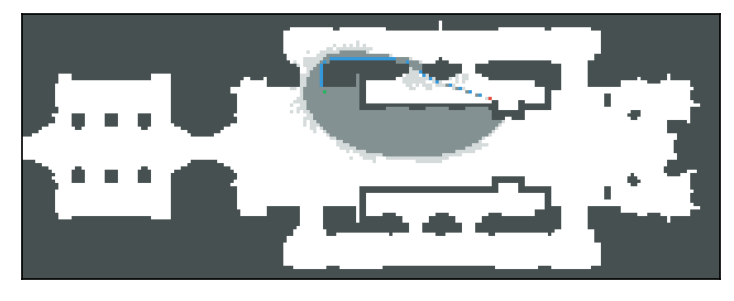

In [16]:
testMap = Map(k = 6)
testMap.ReadFromString(mapstr, width, height)

SimpleTest(AStar, 6, height, width, mapstr, 23, 91, 25, 141, 56.62741699)

Path found! Length: 39.0. Nodes created: 224. Number of steps: 174. Correct: False
CPU times: user 43.5 ms, sys: 498 µs, total: 44 ms
Wall time: 54.7 ms


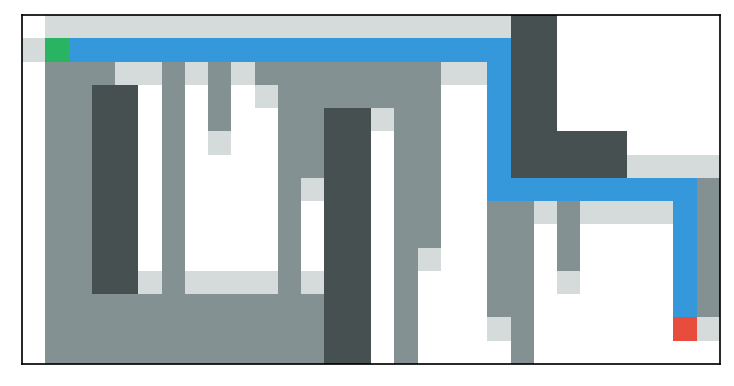

In [ ]:
%%time
testMap = Map(k = 2)
testMap.ReadFromString(mapstr, width, height)
SimpleTest(AStar, 2, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen)

Path found! Length: 31.970562748477146. Nodes created: 159. Number of steps: 123. Correct: True
CPU times: user 63.4 ms, sys: 347 µs, total: 63.7 ms
Wall time: 64.7 ms


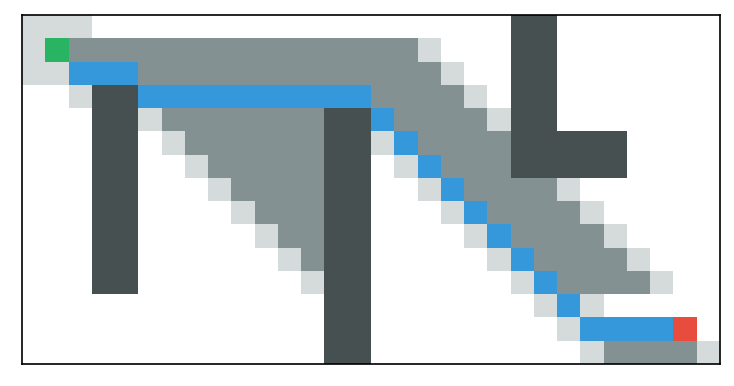

In [ ]:
%%time
testMap = Map(k = 3)
testMap.ReadFromString(mapstr, width, height)
SimpleTest(AStar, 3, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen)

Path found! Length: 30.901689239237314. Nodes created: 116. Number of steps: 86. Correct: False
CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 144 ms


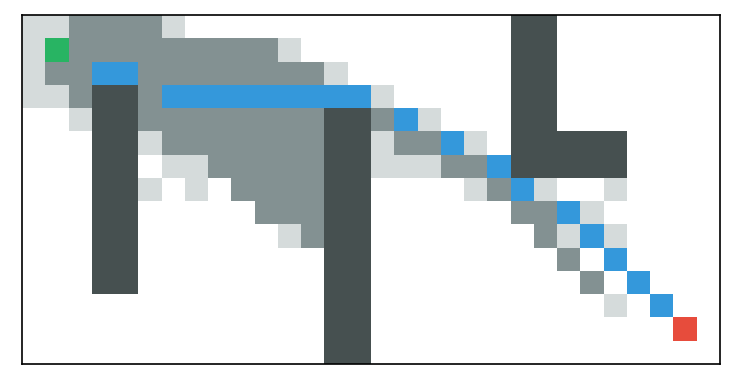

In [ ]:
%%time
testMap = Map(k = 4)
testMap.ReadFromString(mapstr, width, height)
SimpleTest(AStar, 4, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen)

Path found! Length: 30.575187546938903. Nodes created: 123. Number of steps: 74. Correct: False
CPU times: user 368 ms, sys: 0 ns, total: 368 ms
Wall time: 370 ms


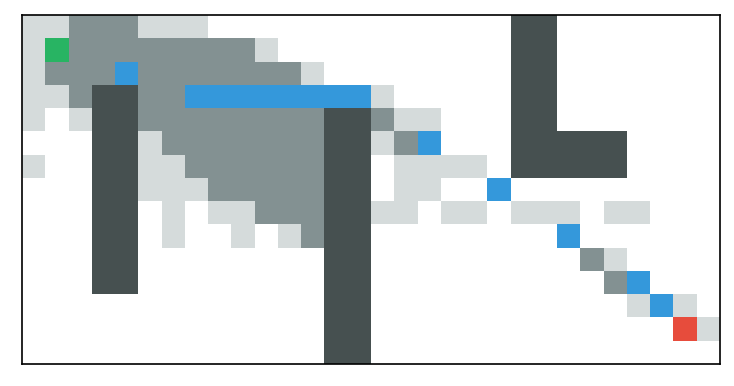

In [ ]:
%%time
testMap = Map(k = 5)
testMap.ReadFromString(mapstr, width, height)
SimpleTest(AStar, 5, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen)

Path found! Length: 30.4573138021633. Nodes created: 143. Number of steps: 68. Correct: False
CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.16 s


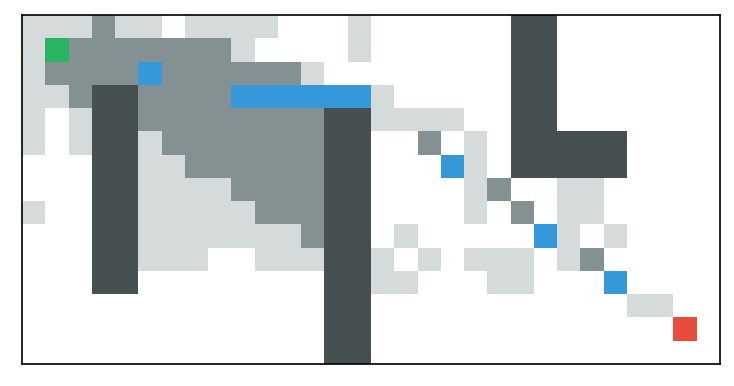

In [ ]:
%%time
testMap = Map(k = 6)
testMap.ReadFromString(mapstr, width, height)
SimpleTest(AStar, 6, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen)

In [ ]:
height = 49
width = 49
mapstr = '''
#################################################
###............####.###...####.####............##
##.............###........###..###.............##
#...............................................#
#...............................................#
#...............................................#
#...............................................#
#.......................##......................#
#......................###......................#
#......................###......................#
#...............................................#
#...............................................#
#...............................................#
#...............................................#
#...............................................#
###............####............####............##
###............####............####............##
###............####............####............##
##.............###.............###.............##
##..............................................#
##..............................................#
##..............................................#
##..............................................#
#...............................................#
#...............................................#
#...............................................#
##..............................................#
###.............................................#
###.............................................#
###.............................................#
#...............................................#
###............####............####............##
###............####............####............##
###............####............####............##
##.............###.............###.............##
#...............................................#
#...............................................#
#...............................................#
#...............................................#
#...............................................#
#...............................................#
#...............................................#
#...............................................#
#...............................................#
#...............................................#
#...............................................#
#...................###...###...................#
###............####.####..####.####............##
#################################################
'''

Path found! Length: 39.914532627848125. Nodes created: 136. Number of steps: 70. Correct: False


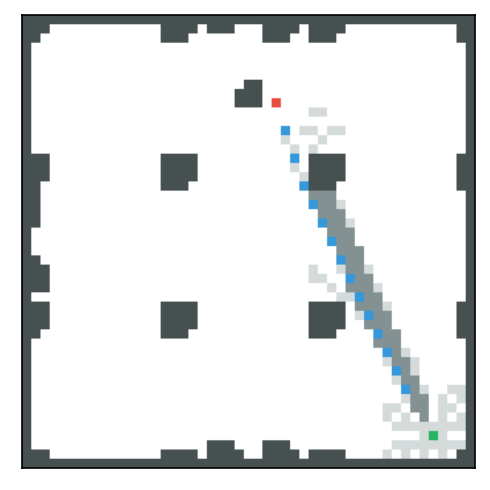

In [ ]:
testMap = Map(k = 6)
testMap.ReadFromString(mapstr, width, height)
SimpleTest(AStar, 6, height, width, mapstr, 45, 44, 9, 27, 1)

## Massive test
Now we will run our search algorithm with different k on a range of different instances from the [[MovingAI](https://movingai.com/benchmarks/grids.html)] benchmark, validate that you get the correct solution in each case and analyze the results.

In [ ]:
# TODO Run tests using different heuristics
from random import shuffle
import pickle

arena_tasks = ReadTasksFromMovingAIFile('dao-scen/arena.map.scen')
den001d_tasks = ReadTasksFromMovingAIFile('dao-scen/den001d.map.scen')

shuffle(arena_tasks)
shuffle(den001d_tasks)
all_tasks = arena_tasks[:100] + den001d_tasks[:100]
with open('all_tasks.pickle', 'wb') as f:
    pickle.dump(all_tasks, f)


In [ ]:
%%time
results_2 = MassiveTest(AStar, 2, all_tasks, 'dao-map/')

with open('results_2.pickle', 'wb') as f:
    pickle.dump(results_2, f)

100%|██████████| 200/200 [00:15<00:00, 12.68it/s]

CPU times: user 15 s, sys: 85 ms, total: 15.1 s
Wall time: 15.8 s


In [ ]:
%%time
results_3 = MassiveTest(AStar, 3, all_tasks, 'dao-map/')

with open('results_3.pickle', 'wb') as f:
    pickle.dump(results_3, f)

100%|██████████| 200/200 [00:41<00:00,  4.77it/s]

CPU times: user 41.5 s, sys: 121 ms, total: 41.6 s
Wall time: 42 s


In [ ]:
%%time
results_4 = MassiveTest(AStar, 4, all_tasks, 'dao-map/')
    
with open('results_4.pickle', 'wb') as f:
    pickle.dump(results_4, f)

100%|██████████| 200/200 [02:26<00:00,  1.37it/s]

CPU times: user 2min 25s, sys: 343 ms, total: 2min 25s
Wall time: 2min 26s


In [ ]:
%%time
results_5 = MassiveTest(AStar, 5, all_tasks, 'dao-map/')
  
with open('results_5.pickle', 'wb') as f:
    pickle.dump(results_5, f)

100%|██████████| 200/200 [09:19<00:00,  2.80s/it]

CPU times: user 9min 16s, sys: 1.16 s, total: 9min 17s
Wall time: 9min 19s


In [ ]:
%%time
results_6 = MassiveTest(AStar, 6, all_tasks, 'dao-map/')

with open('results_6.pickle', 'wb') as f:
    pickle.dump(results_6, f)

100%|██████████| 200/200 [38:54<00:00, 11.67s/it]

CPU times: user 38min 45s, sys: 4.34 s, total: 38min 49s
Wall time: 38min 54s


In [4]:
import pickle

with open('all_tasks.pickle', 'rb') as f:
    all_tasks = pickle.load(f)

with open('results_2.pickle', 'rb') as f:
    results_2 = pickle.load(f)

with open('results_3.pickle', 'rb') as f:
    results_3 = pickle.load(f)
    
with open('results_4.pickle', 'rb') as f:
    results_4 = pickle.load(f)
  
with open('results_5.pickle', 'rb') as f:
    results_5 = pickle.load(f)

with open('results_6.pickle', 'rb') as f:
    results_6 = pickle.load(f)

with open('theta_results.pickle', 'rb') as f:
    theta_results = pickle.load(f)

with open('a_star_results.pickle', 'rb') as f:
    a_star_results = pickle.load(f)

## Analyze the results

Среднее время выполнения одной задачи растёт экспоненциально с ростом k. Это связано с тем, что количество последователей растёт экспоненциально от k.

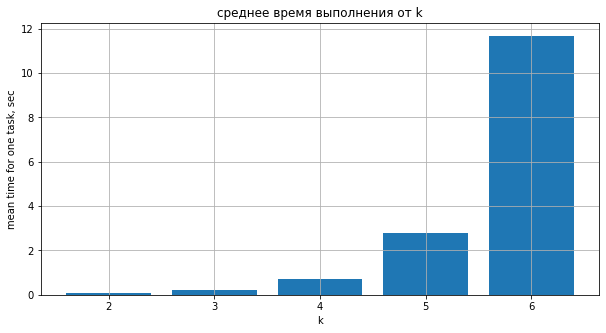

In [145]:
x = [2, 3, 4, 5, 6]
y = [15.8/200, 42/200, (2*60 + 26)/200, (9*60 + 19)/200, (38*60 + 54)/200]
plt.figure(figsize=[10, 5])
plt.bar(x, y)
plt.title('среднее время выполнения от k')
plt.xlabel('k')
plt.ylabel('mean time for one task, sec')
plt.grid()

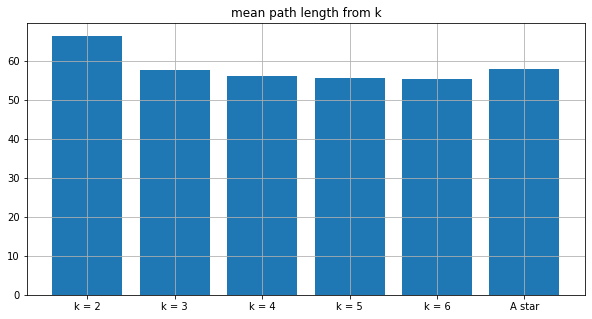

In [8]:
plt.figure(figsize=[10, 5])
k = ['k = 2', 'k = 3', 'k = 4', 'k = 5', 'k = 6', 'A star']
lengths = [np.mean(results_2['length']), 
         np.mean(results_3['length']), 
         np.mean(results_4['length']), 
         np.mean(results_5['length']),
         np.mean(results_6['length']),
         np.mean(results_2['true_length'])]
plt.bar(k, lengths)
plt.title('mean path length from k')
plt.grid()

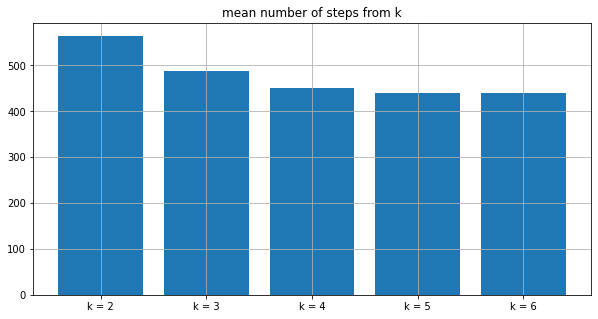

In [146]:
plt.figure(figsize=[10, 5])
k = ['k = 2', 'k = 3', 'k = 4', 'k = 5', 'k = 6']
steps = [np.mean(results_2['number_of_steps']), 
         np.mean(results_3['number_of_steps']), 
         np.mean(results_4['number_of_steps']), 
         np.mean(results_5['number_of_steps']),
         np.mean(results_6['number_of_steps'])]
plt.bar(k, steps)
plt.title('mean number of steps from k')
plt.grid()

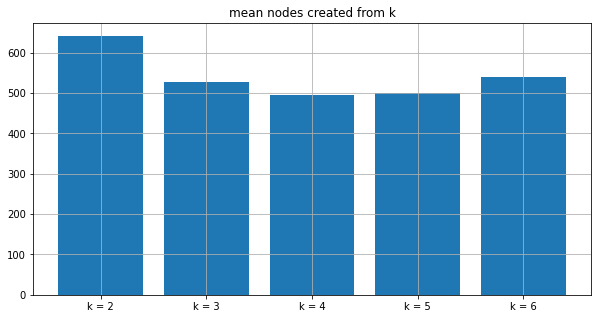

In [ ]:
plt.figure(figsize=[10, 5])
k = ['k = 2', 'k = 3', 'k = 4', 'k = 5', 'k = 6']
steps = [np.mean(results_2['nodes_created']), 
         np.mean(results_3['nodes_created']), 
         np.mean(results_4['nodes_created']), 
         np.mean(results_5['nodes_created']),
         np.mean(results_6['nodes_created'])]
plt.bar(k, steps)
plt.title('mean nodes created from k')
plt.grid()

In [ ]:
# метод для вывода основных результатов и графиков
def report(results):
    found = np.array(results['found'])
    is_optimal = np.array(results['is_optimal'])
    length = np.array(results['length'])
    true_length = np.array(results['true_length'])
    nodes_created = np.array(results['nodes_created'])
    number_of_steps = np.array(results['number_of_steps'])
    
    print('Found path ratio: ', np.mean(found))
    #print('Optimal path ratio: ', is_optimal[found].mean())
    print('Mean A star length: ', np.mean(true_length))
    print('Mean 2**k A star length: ', np.mean(length))
    print('Mean path error: ', np.abs(1 - (1e-7 + length[found]) / (1e-7 + true_length[found])).mean())
    print('Mean number of steps: ', number_of_steps.mean())
    print('Mean nodes created: ', np.mean(nodes_created))
    
    plt.figure(figsize=[15, 5])
    
    plt.subplot(1, 2, 1)
    plt.scatter(true_length, nodes_created)
    plt.yscale('log')
    plt.xlabel('Path length')
    plt.ylabel('Number of created nodes, log scale')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.scatter(true_length, number_of_steps)
    plt.yscale('log')
    plt.xlabel('Path length')
    plt.ylabel('Number of steps, log scale')
    plt.grid()

Found path ratio:  1.0
Mean A star length:  57.933106750099995
Mean 2**k A star length:  66.315
Mean path error:  0.18039281237345228
Mean number of steps:  564.445
Mean nodes created:  641.43


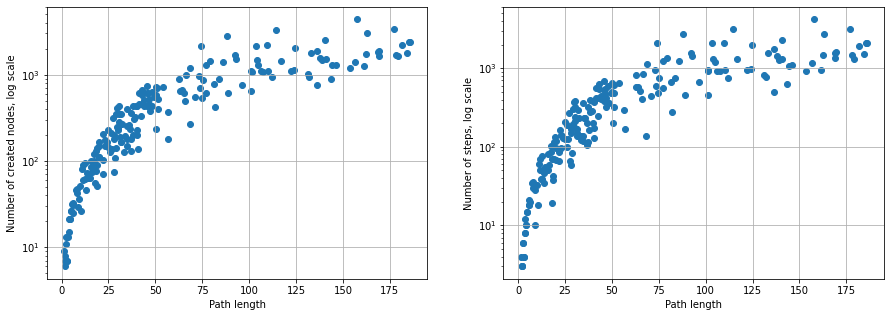

In [ ]:
report(results_2)

Found path ratio:  1.0
Mean A star length:  57.933106750099995
Mean 2**k A star length:  57.620213536864185
Mean path error:  0.005661921903266087
Mean number of steps:  488.765
Mean nodes created:  528.13


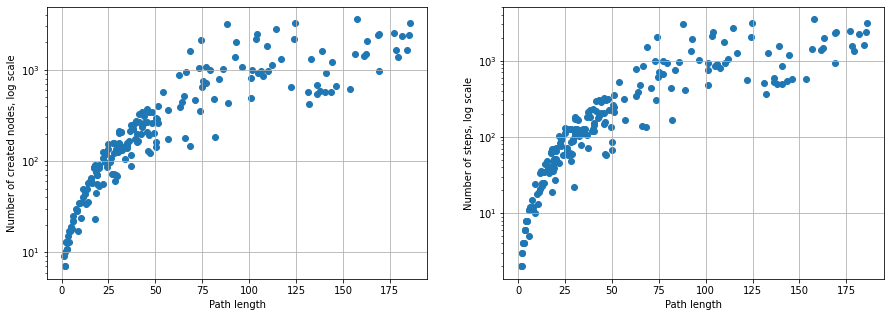

In [ ]:
report(results_3)

Found path ratio:  1.0
Mean A star length:  57.933106750099995
Mean 2**k A star length:  55.93166111219342
Mean path error:  0.03963362232811013
Mean number of steps:  451.935
Mean nodes created:  494.735


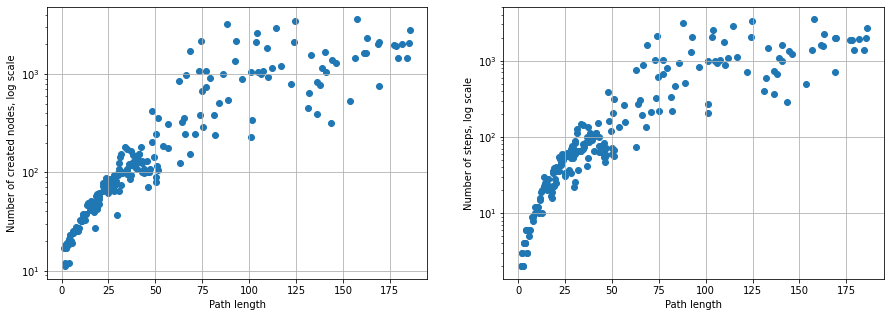

In [ ]:
report(results_4)

Found path ratio:  1.0
Mean A star length:  57.933106750099995
Mean 2**k A star length:  55.51161387699372
Mean path error:  0.04742622728694343
Mean number of steps:  439.595
Mean nodes created:  500.005


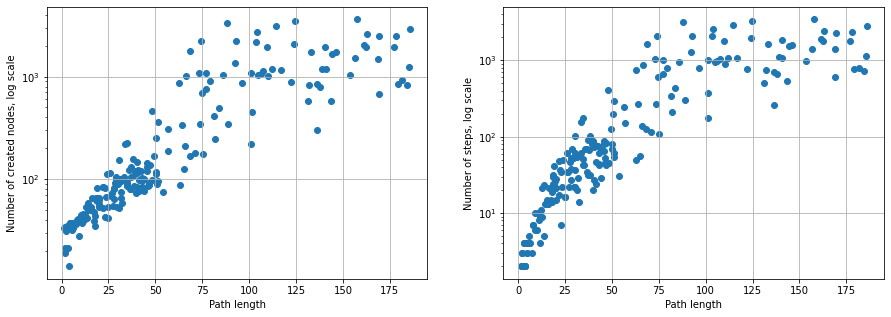

In [ ]:
report(results_5)

Found path ratio:  1.0
Mean A star length:  57.933106750099995
Mean 2**k A star length:  55.370522369824215
Mean path error:  0.04977742869378842
Mean number of steps:  440.875
Mean nodes created:  540.275


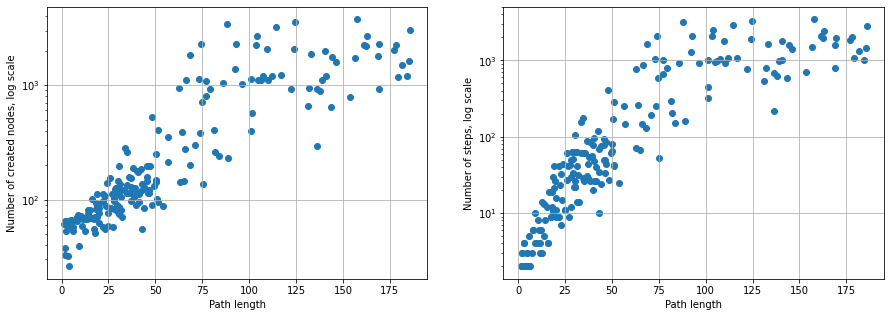

In [ ]:
report(results_6)

# Сравнение алгоритмов

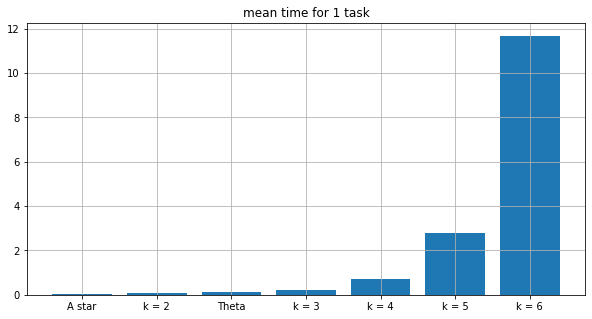

In [7]:
plt.figure(figsize=[10, 5])
x = ['A star', 'k = 2', 'Theta', 'k = 3', 'k = 4', 'k = 5', 'k = 6']
time = [8.92/200, 
         15.8/200, 
         28.9/200,
         42/200, 
         (2*60 + 26)/200,
         (9*60 + 19)/200,
         (38*60 + 54)/200]
plt.bar(x, time)
plt.title('mean time for 1 task')
plt.grid()

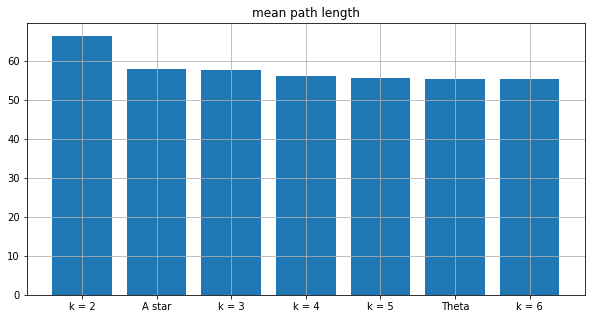

In [18]:
plt.figure(figsize=[10, 5])
k = ['k = 2', 'A star', 'k = 3', 'k = 4', 'k = 5', 'Theta', 'k = 6']
lengths = [np.mean(results_2['length']),
         np.mean(a_star_results['length']),   
         np.mean(results_3['length']), 
         np.mean(results_4['length']), 
         np.mean(results_5['length']),
         np.mean(theta_results['length']),
         np.mean(results_6['length'])]
plt.bar(k, lengths)
plt.title('mean path length')
plt.grid()

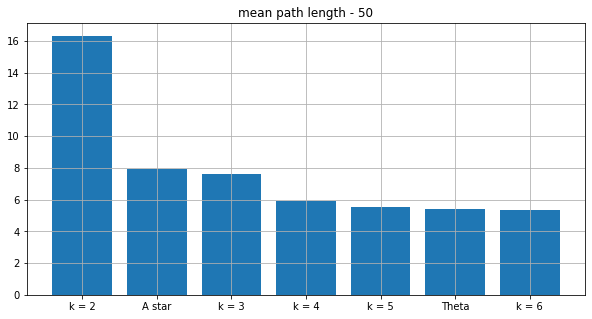

In [21]:
plt.figure(figsize=[10, 5])
x = ['k = 2', 'A star', 'k = 3', 'k = 4', 'k = 5', 'Theta', 'k = 6']
lengths = [np.mean(results_2['length']) - 50, 
         np.mean(a_star_results['length']) - 50,  
         np.mean(results_3['length']) - 50, 
         np.mean(results_4['length']) - 50, 
         np.mean(results_5['length']) - 50,
         np.mean(theta_results['length']) - 50,
         np.mean(results_6['length']) - 50]
plt.bar(x, lengths)
plt.title('mean path length - 50')
plt.grid()

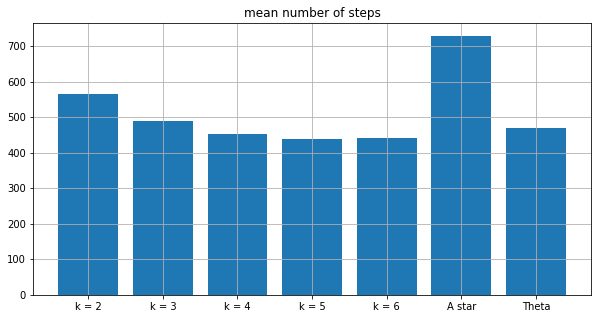

In [22]:
plt.figure(figsize=[10, 5])
x = ['k = 2', 'k = 3', 'k = 4', 'k = 5', 'k = 6', 'A star', 'Theta']
steps = [np.mean(results_2['number_of_steps']), 
         np.mean(results_3['number_of_steps']), 
         np.mean(results_4['number_of_steps']), 
         np.mean(results_5['number_of_steps']),
         np.mean(results_6['number_of_steps']),
         np.mean(a_star_results['number_of_steps']),
         np.mean(theta_results['number_of_steps'])]
plt.bar(x, steps)
plt.title('mean number of steps')
plt.grid()

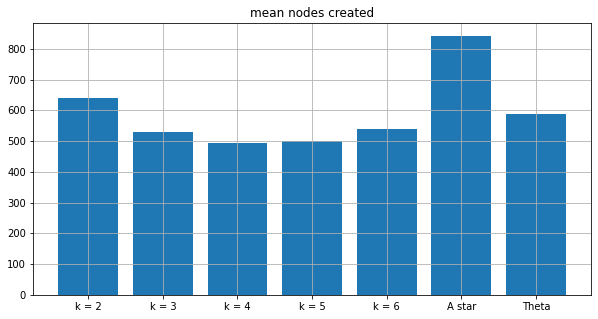

In [23]:
plt.figure(figsize=[10, 5])
x = ['k = 2', 'k = 3', 'k = 4', 'k = 5', 'k = 6', 'A star', 'Theta']
nodes = [np.mean(results_2['nodes_created']), 
         np.mean(results_3['nodes_created']), 
         np.mean(results_4['nodes_created']), 
         np.mean(results_5['nodes_created']),
         np.mean(results_6['nodes_created']),
         np.mean(a_star_results['nodes_created']),
         np.mean(theta_results['nodes_created'])]
plt.bar(x, nodes)
plt.title('mean nodes created')
plt.grid()